In [30]:
"""
Solving the Black Jack via reinforcement learning to find the optimal strategy:
- via Dynamic Programming (RL)
- via Monte Carlo methods (on-policy and off-policy)

Rules of the Black Jack here (one vs one against the dealer):
- if sum of the card goes above 21, you bust (lose), else you can stick or hit
- dealer has deterministic way of playing: sticks if higher than 17, else hits
- the ace can count as either 1 or 11, and you start with 2 cards
- you see one of the card of the dealer
- the number of cards is INFINITE
"""

from collections import *
from dataclasses import *
import enum
from functools import lru_cache
import itertools
import numpy as np
from typing import *

%matplotlib inline
import matplotlib
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import numpy
# from PIL import Image

In [31]:
"""
Implementation of the game of Blackjack
"""


class Action(enum.Enum):
    STICK = 0
    HIT = 1


@dataclass(frozen=True)
class VisibleState:
    dealer_card: int
    current_total: int
    has_usable_ace: bool

        
class Hand:
    DECK = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]
    
    def __init__(self, cards):
        self.cards = list(cards)
    
    @classmethod
    def random(cls):
        return cls(cards=np.random.choice(cls.DECK, size=2))
    
    def pick_card(self):
        self.cards.append(np.random.choice(self.DECK))
    
    @property
    def first_card(self):
        return self.cards[0]
    
    @property
    def total(self) -> int:
        return self.state[0]
    
    @property
    def state(self) -> Tuple[int, bool]:
        total = 0
        usable_ace = 0
        for card in self.cards:
            if card == 1:
                total += 11
                usable_ace += 1
            else:
                total += card
            if total > 21 and usable_ace > 0:
                total -= 10
                usable_ace -= 1
        return total, usable_ace

    
Reward = int


class BlackJack:
    def __init__(self):
        self.dealer = None
        self.player = None
        self.is_over = False
        self.reset()
    
    def reset(self):
        self.dealer = Hand.random()
        self.player = Hand.random()
        self.is_over = False
    
    def get_state(self) -> VisibleState:
        total, usable_ace = self.player.state
        return VisibleState(
            dealer_card = self.dealer.first_card,
            current_total = total,
            has_usable_ace = usable_ace > 0)
    
    def get_actions(self) -> List[Action]:
        return [Action.STICK, Action.HIT]
    
    def is_done(self) -> bool:
        return self.is_over
    
    def play(self, action) -> Reward:
        if action == Action.HIT:
            self.player.pick_card()
            if self.player.total > 21:
                self.is_over = True
                return -1
            else:
                return 0
        elif action == Action.STICK:
            self.is_over = True
            self._dealer_move()
            if self.dealer.total > 21:
                return 1
            elif self.dealer.total == self.player.total == 21:
                return 0
            elif self.player.total > self.dealer.total:
                return 1
            else:
                return -1
        else:
            return -1 # Invalid action: you loose
    
    def _dealer_move(self):
        if self.dealer.total < 17:
            self.dealer.pick_card()

In [17]:
hand = Hand(cards=[1, 6, 1])
print(hand.state)

(18, 1)


In [3]:
"""
Classical Policity Iteration:
- first do some rounds of "Policy Evaluation": improve the state value V (or action value Q) under the current policy P
- then adapt the policy P to become greedy regarding the state value V (or action value Q)
- keep on doing this while there are some changes in the policy P (or enough change in V or Q)

There are several ways to try to perform the Policy Valuation:
- via Dymanic Programming: you open all possibilities and just look at the next step (requires to know the dynamic of the game)
- via Monte Carlo (either on-policy or off-policy): you generate some games to find the state value V (or action value Q)
- via Temporal Learning (TODO)
"""

'\nClassical Policity Iteration:\n- first do some rounds of "Policy Evaluation": improve the state value V (or action value Q) under the current policy P\n- then adapt the policy P to become greedy regarding the state value V (or action value Q)\n- keep on doing this while there are some changes in the policy P (or enough change in V or Q)\n\nThere are two ways to try to perform the Policy Valuation:\n- via Dymanic Programming: you open all possibilities and just look at the next step (requires to know the dynamic of the game)\n- via Monte Carlo (either on-policy or off-policy): you generate some games to find the state value V (or action value Q)\n'

In [55]:
"""
Dynamic Programming way of doing the "Policy Evaluation":

The "Bellman Update" is used for the Policy Evaluation:
- unroll the equation of the state value V (or action value Q), to turn it into an update rule
- by introducing "time" in order to use the same notion as in typical Dynamic Programming)

V(s)   = Expected[a ~ policy] { Q(s, a) }
Q(s,a) = Expected[(r,s') ~ p] {r + gamma * V(s')} 

Becomes (for state evaluation - but the action evaluation is not especially useful as the model is fully known in DP):

V(s) = Expected[a ~ policy] { Expected[(r,s') ~ p] {r + gamma * V(s')} }

The Policy Evaluation algorithm itself becomes:

    initialize all V(s) arbitrarily (except terminal states to 0)
    max_diff = 0.
    while max_diff < epsilon:
        max_diff = 0.
        for each state s:
            previous_v = V(s)
            V(s) = Expected[a ~ policy] { Expected[(r,s') ~ p] {r + gamma * V(s')} }
            max_diff = max(max_diff, abs(previous_v - V(s)))
    return all V(s)

But this really hard in practice, since you need to know the distribution of probability p for (s', r) given (s, a)
"""


@dataclass(frozen=True)
class BlackJackTransition:
    probability: float
    reward: float
    state: VisibleState    # None if we reached the end of the game


class BlackJackModel:
    def __init__(self):
        self.card_probs = OrderedDict()
        for card in Hand.DECK:
            self.card_probs[card] = self.card_probs.get(card, 0) + 1 / len(Hand.DECK)
    
    @lru_cache(maxsize=None)
    def on_action(self, state: VisibleState, action: Action) -> List[BlackJackTransition]:
        if action == Action.HIT:
            return list(self._on_hit(state))
        else:
            return list(self._on_stick(state))
    
    def _on_hit(self, state: VisibleState) -> Generator[BlackJackTransition, None, None]:
        for card, prob in self.card_probs.items():
            hand = Hand(cards=[state.current_total]) if not state.has_usable_ace else Hand(cards=[state.current_total-10, 1])
            hand.cards.append(card)
            total, usable_ace = hand.state
            new_state = VisibleState(dealer_card=state.dealer_card, current_total=total, has_usable_ace=usable_ace > 0)
            if total > 21:
                yield BlackJackTransition(probability=prob, reward=-1, state=None)
            else:
                yield BlackJackTransition(probability=prob, reward=0, state=new_state)
    
    def _on_stick(self, state: VisibleState) -> Generator[BlackJackTransition, None, None]:
        for card, prob in self.card_probs.items():
            dealer_hand = Hand(cards=[state.dealer_card, card])
            yield from self._on_dealer_turn(state, dealer_hand, prob)

    def _on_dealer_turn(self, state: VisibleState, dealer_hand: Hand, prob: float) -> Generator[BlackJackTransition, None, None]:
        if dealer_hand.total > 21:
            yield BlackJackTransition(probability=prob, reward=1, state=None)
        elif dealer_hand.total == 21 and state.current_total == 21:
            yield BlackJackTransition(probability=prob, reward=0, state=None)
        elif dealer_hand.total >= 17:
            reward = 1 if state.current_total > dealer_hand.total else -1
            yield BlackJackTransition(probability=prob, reward=reward, state=None)
        else:
            for card, card_prob in self.card_probs.items():
                new_dealer_hand = Hand(dealer_hand.cards)
                new_dealer_hand.cards.append(card)
                yield from self._on_dealer_turn(state, new_dealer_hand, prob=prob*card_prob)


def dp_state_values_evaluations(mode: BlackJackModel, policy, reward_discount_factor: float, iteration_count: int):
    state_values = {
        VisibleState(dealer_card=dealer_card,
                     current_total=current_total,
                     has_usable_ace=has_usable_ace) : 0.
        for dealer_card in range(1, 11)
        for current_total in range(2, 22)
        for has_usable_ace in (False, True)
    }
    
    def expected_value(state, action):
        value = 0.
        for transition in model.on_action(state, action):
            next_state_value = state_values[transition.state] if transition.state else 0.
            score = transition.reward + reward_discount_factor * next_state_value
            value += transition.probability * score
        return value
    
    for _ in range(iteration_count):
        for state in state_values.keys():
            state_values[state] = expected_value(state, policy(state))
    return state_values


def initial_policy(state: VisibleState):
    if state.current_total < 20:
        return Action.HIT
    else:
        return Action.STICK

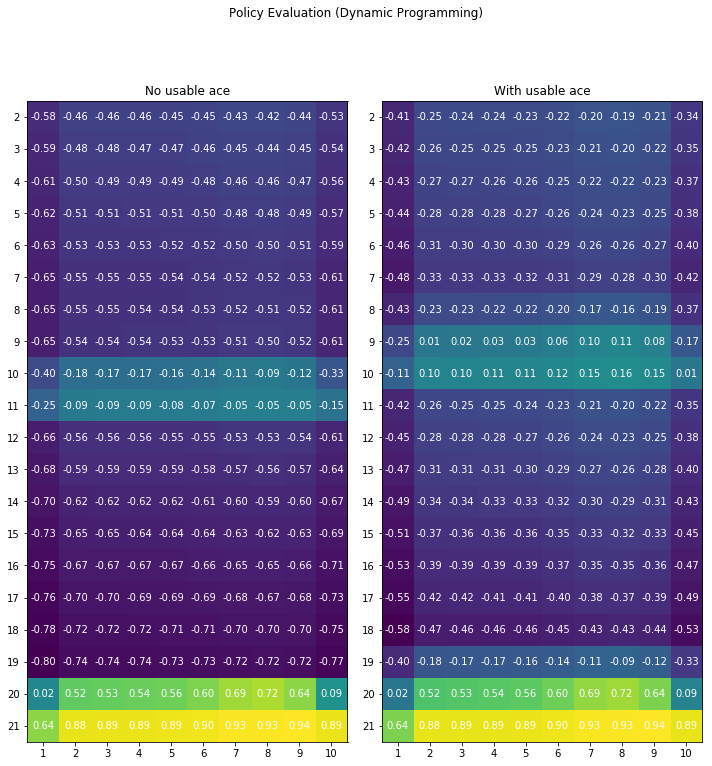

In [73]:
"""
Demonstrating the Policy Evaluation via Dynamic Programming
"""


def show_values(state_values: Dict[VisibleState, float], title: str = ""):
    player_totals = list(range(2, 21 + 1))
    dealer_cards = list(range(1, 10 + 1))
    no_ace = np.zeros((len(player_totals), len(dealer_cards)))
    with_ace = np.zeros((len(player_totals), len(dealer_cards)))

    for i, player_total in enumerate(player_totals):
        for j, dealer_card in enumerate(dealer_cards):
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False)
            no_ace[i,j] = state_values[state]
            state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=True)
            with_ace[i,j] = state_values[state]

    fig, ax = plt.subplots(figsize=(10, 12), ncols=2)
    ax[0].imshow(no_ace)
    ax[1].imshow(with_ace)
    ax[0].set_title("No usable ace")
    ax[1].set_title("With usable ace")
    if title:
        fig.suptitle(title)
    
    for col, val_map in enumerate([no_ace, with_ace]):
        ax[col].set_yticks(np.arange(len(player_totals)))
        ax[col].set_xticks(np.arange(len(dealer_cards)))
        ax[col].set_yticklabels(player_totals)
        ax[col].set_xticklabels(dealer_cards)
        for i in range(len(player_totals)):
            for j in range(len(dealer_cards)):
                label = "{0:.2f}".format(val_map[i, j])
                ax[col].text(j, i, label, ha="center", va="center", color="w")
    plt.tight_layout()
    plt.show()
    

model = BlackJackModel()
state_values_dp = dp_state_values_evaluations(model, initial_policy, reward_discount_factor=1., iteration_count=5)
show_values(state_values_dp, title="Policy Evaluation (Dynamic Programming)")

In [51]:
"""
Monte Carlo of doing the "Policy Evaluation" following an "on-policy" approach:
- we use the policy to generate new scenarios
- and we keep track of the states and reward to estimate the value

Here we evaluate the state value V, although in the end, this is not very useful:
- if we do not know the model, we cannot really use it to take a decision (can't look ahead to next value)
- in such cases, it is either useful to try to evaluate the probability p(s',r|s,a) of the model or to search Q instead of V
"""


class StateValues:
    def __init__(self):
        self.state_values: Dict[VisibleState, float] = defaultdict(float)
        self.state_counts: Dict[VisibleState, int] = defaultdict(int)
    
    def add(self, state: VisibleState, score: float):
        self.state_values[state] += 1 / (self.state_counts[state] + 1) * (score - self.state_values[state])
        self.state_counts[state] += 1
    
    def __getitem__(self, state: VisibleState):
        return self.get_value(state)
    
    def get_value(self, state: VisibleState):
        return self.state_values.get(state, float('nan'))
    
    def get_count(self, state: VisibleState):
        return self.state_counts.get(state, 0)


def every_visit_monte_carlo_policy_state_evaluation(game: BlackJack, gamma: float, nb_episodes: int, policy) -> StateValues:
    state_values = StateValues()
    
    for _ in range(nb_episodes):
        game.reset()
        
        states, rewards = [], []
        while not game.is_over:
            state = game.get_state()
            action = policy(state)
            reward = game.play(action)
            states.append(state)
            rewards.append(reward)
        
        score = 0.
        for i in reversed(range(len(states))):
            score = rewards[i] + gamma * score
            state_values.add(states[i], score)
    
    return state_values

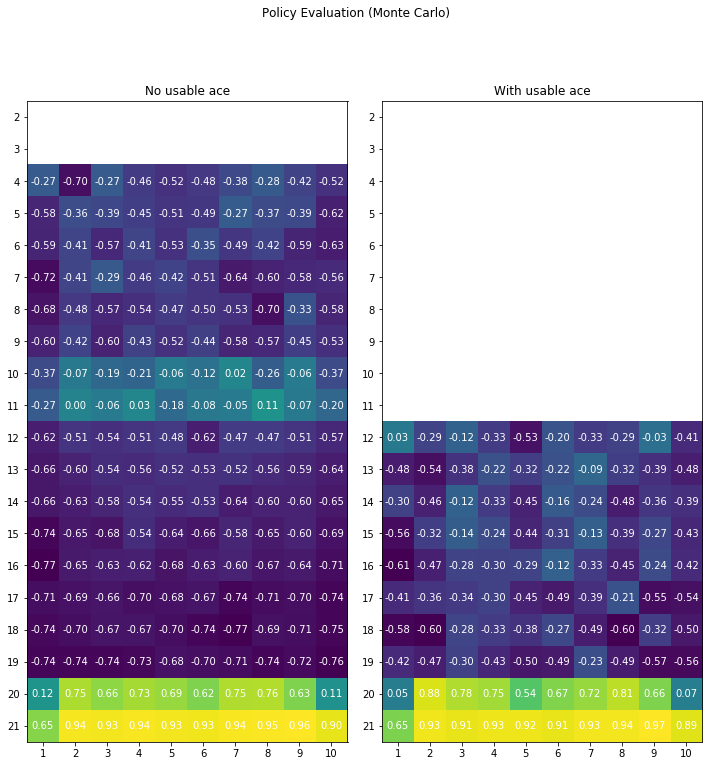

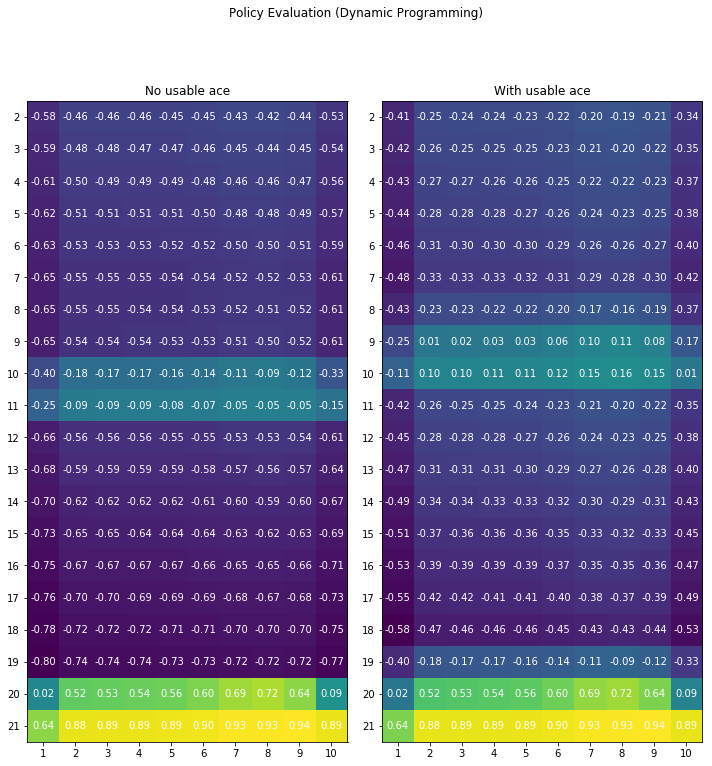

In [75]:
"""
Example of action values, following the policy HIT below 20, and STICK otherwise

PROBLEM HERE:
- the initial states are rather imbalanced... low probability to hit a 4 or 5 value
- so I do not display them here, knowing that the strategy is pretty clear here

BUT IN A REAL GAME, that would be a problem.
"""


state_values_mc = every_visit_monte_carlo_policy_state_evaluation(
    game=BlackJack(),
    gamma=1.,
    nb_episodes=50_000,
    policy=initial_policy)



show_values(state_values_mc, title="Policy Evaluation (Monte Carlo)")
show_values(state_values_dp, title="Policy Evaluation (Dynamic Programming)")

In [7]:
"""
If we search to evaluate Q instead of V, we face the problem of having to try all possibles (s,a):
- either we need to try every possible (s, a) as starting action
- or we need to introduce some randomness in our policy (epsilon greedy policy) else it will only select the same action

If we introduce some randomness, we must realize we do not solve the original problem, but solve a problem of finding the optimal
policy in an environment that does not not really select our chosen action all the time.
"""


class ActionValues:
    def __init__(self):
        self.action_values: Dict[VisibleState, Dict[Action, float]] = defaultdict(lambda: defaultdict(float))
        self.action_counts: Dict[VisibleState, Dict[Action, int]] = defaultdict(lambda: defaultdict(int))
    
    def add(self, state: VisibleState, action: Action, score) -> float:
        prev_value = self.action_values[state][action]
        self.action_values[state][action] += 1 / (self.action_counts[state][action] + 1) * (score - self.action_values[state][action])
        self.action_counts[state][action] += 1
        return self.action_values[state][action] - prev_value
    
    def get_states(self):
        return self.action_values.keys()
    
    def get_best_action(self, state: VisibleState) -> Action:
        best_action = None
        best_score = float('-inf')
        for action, score in self.action_values[state].items():
            if score > best_score:
                best_score = score
                best_action = action
        return best_action
    
    def __len__(self):
        return sum(len(actions) for state, actions in self.action_values.items())


def with_epsilon_random_action(actions: List[Action], epsilon: float, policy):
    def epsilon_policy(state: VisibleState):
        if np.random.uniform(0, 1) < epsilon:
            return np.random.choice(actions)
        else:
            return policy(state)
    return epsilon_policy


def every_visit_monte_carlo_policy_action_evaluation(
    game: BlackJack,
    gamma: float,
    policy,
    nb_episodes: int = 0,
    stable_below_delta: int = 0,
    evaluation_delta: float = 0.) -> ActionValues:
    
    action_values = ActionValues()
    count_below_delta = 0
    
    for episode in itertools.count(0):
        if nb_episodes and episode >= nb_episodes:
            break
            
        if stable_below_delta and count_below_delta >= stable_below_delta:
            break
        
        game.reset()
        transitions = []
        rewards = []
        while not game.is_over:
            state = game.get_state()
            action = policy(state)
            reward = game.play(action)
            transitions.append((state, action))
            rewards.append(reward)
        
        score = 0.
        for i in reversed(range(len(transitions))):
            state, action = transitions[i]
            reward = rewards[i]
            score = reward + gamma * score
            diff = action_values.add(state, action, score)
            
            if evaluation_delta:
                if diff > evaluation_delta:
                    count_below_delta = 0
                else:
                    count_below_delta += 1

    return action_values

In [54]:
action_values = every_visit_monte_carlo_policy_action_evaluation(
    game=BlackJack(),
    gamma=1.,
    # nb_episodes=10_000,
    stable_below_delta=500,
    evaluation_delta = 0.1,
    policy=with_epsilon_random_action([Action.HIT, Action.STICK], 0.1, initial_policy))


print(len(action_values)) # Should be up to 10 (dealer card) * (21-2) (total for player) * 2 (ace or not ace) * 2 (actions) = 760

513


In [9]:
"""
Policy improvement: Update a policy to take the greedy action
"""


class Policy:
    def __init__(self, epsilon):
        self.decisions = {}
        self.epsilon = epsilon
    
    def __call__(self, state: VisibleState) -> Action:
        action = self.decisions.get(state, Action.HIT)
        if np.random.uniform(0, 1) < self.epsilon:
            return Action.STICK if action == Action.HIT else Action.HIT
        return action
    
    def improve(self, action_values: ActionValues) -> bool:
        any_modification = False
        for state in action_values.get_states():
            previous_decision = self.decisions.get(state, None)
            new_decision = action_values.get_best_action(state)
            if new_decision != previous_decision:
                self.decisions[state] = new_decision
                any_modification = True
        return any_modification
    
    def __repr__(self):
        return repr(self.decisions)


"""
Policy Iteration:
- Keep on evaluating the current policy (Policy Evaluation) then trying Policy Improvement
- Stop when there are no more improvements
"""


def policy_iteration(game: BlackJack, policy: Policy, max_iteration: int = None):
    any_modification = True
    for iteration in itertools.count(0):
        if max_iteration and iteration >= max_iteration:
            break
        
        if iteration % 10 == 0:
            print("Iteration:", iteration)
        
        action_values = every_visit_monte_carlo_policy_action_evaluation(
            game=game, gamma=1.,
            # nb_episodes=10_000,
            stable_below_delta=500,
            evaluation_delta = 0.1,
            policy=policy)
        any_modification = policy.improve(action_values)
        if not any_modification:
            break

In [10]:
def create_initial_policy(epsilon: float):
    policy = Policy(epsilon=epsilon)
    for player_total in range(3, 21+1):
        for dealer_card in range(1, 10 + 1):
            for has_ace in (True, False):
                state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=has_ace)
                policy.decisions[state] = Action.HIT if player_total < 20 else Action.STICK
    return policy

game = BlackJack()
policy = create_initial_policy(epsilon=0.1)
policy_iteration(game, policy=policy, max_iteration=100)

Iteration: 0
Iteration: 10
Iteration: 20
Iteration: 30
Iteration: 40
Iteration: 50
Iteration: 60
Iteration: 70
Iteration: 80
Iteration: 90


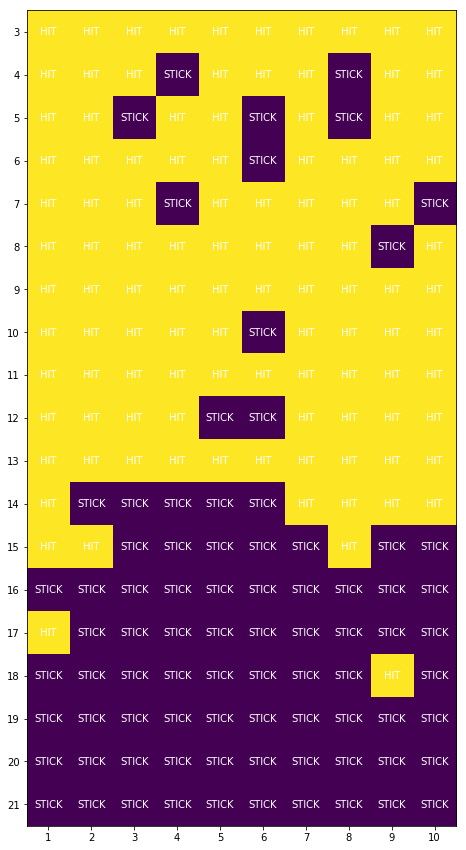

In [11]:
"""
A nice representation of the policy based on a matrix
"""

# TODO - remove the epsilon...
policy.epsilon = -1.0

player_totals = list(range(3, 21 + 1))
dealer_cards = list(range(1, 10 + 1))
no_ace = np.zeros((len(player_totals), len(dealer_cards)))

for i, player_total in enumerate(player_totals):
    for j, dealer_card in enumerate(dealer_cards):
        state = VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False)
        action = policy(state)
        no_ace[i,j] = 1 if action == Action.HIT else 0

fig, ax = plt.subplots(figsize=(15, 15))
im = ax.imshow(no_ace)

ax.set_yticks(np.arange(len(player_totals)))
ax.set_xticks(np.arange(len(dealer_cards)))
ax.set_yticklabels(player_totals)
ax.set_xticklabels(dealer_cards)

for i in range(len(player_totals)):
    for j in range(len(dealer_cards)):
        action_label = "HIT" if no_ace[i, j] == 1 else "STICK"
        text = ax.text(j, i, action_label, ha="center", va="center", color="w")

plt.show()

In [12]:
"""
Now playing with a QAgent that:
1. Does not systematically reset its action values (Q values) - the policy evaluation will generally not change everything
2. Is based on value iteration

It converges really fast and produce quality game plans
"""


# TODO - explicit representation of the policy


@dataclass(frozen=True)
class ActionOutcome:
    probability: float
    state: Any
    reward: float
        

class LearnedModel:
    """
    Attempt at modeling the probability (new_state, reward | state, action) of the environment.
    """
    
    def __init__(self):
        self._transitions = defaultdict(Counter)     # map tuple (state, action) to expected target states (with prob)
        self._rewards = defaultdict(float)           # map tuple (state, action, new_state) to reward
        self._total_transitions = Counter()
    
    def add(self, state, action, new_state, reward):
        self._rewards[(state, action, new_state)] = reward
        self._transitions[(state, action)][new_state] += 1
        self._total_transitions[(state, action)] += 1
    
    def outcomes(self, state, action):
        total_transitions = self._total_transitions[(state, action)]
        for new_state, count in self._transitions[(state, action)].items():
            yield ActionOutcome(
                probability=count/total_transitions,
                state=new_state,
                reward=self._rewards[(state, action, new_state)])   


class QValues:
    """
    Map state and action to an expected reward
    """
    
    def __init__(self, default_value: float = 0.):
        self.default_value = default_value     # a big value might help favoring exploration at early stages (but biase the results)
        self.actions = defaultdict(list)       # map state to possible actions at that state
        self.q_values = defaultdict(lambda: defaultdict(float))
    
    def set_actions(self, state, actions):
        self.actions[state] = actions
    
    def get_actions(self, state):
        return self.actions[state]
    
    def get_state_value(self, state):
        if self.actions[state]:
            return self.most_valuable_action(state)[1]
        return self.default_value
    
    def most_valuable_action(self, state):
        best_action = None
        best_value = float('-inf')        
        for action in self.actions[state]:
            value = self.q_values[state].get(action, self.default_value)
            if value > best_value:
                best_action = action
                best_value = value
        return best_action, best_value
    
    def bellman_update(self, state, action, learned_model, blending: float, reward_discount: float):
        expected_reward = 0.
        expected_value = 0.
        for outcome in learned_model.outcomes(state, action):
            expected_reward += outcome.probability * outcome.reward
            expected_value += outcome.probability * self.get_state_value(outcome.state)        
        self.q_values[state][action] = \
            (1 - blending) * self.q_values[state][action] + \
            blending * (expected_reward + reward_discount * expected_value)


class QAgent:
    def __init__(self,
                 reward_discount: float=1.0,
                 temperature: float=1.0):
        self.temperature = temperature          # controls the number of random actions attempted
        self.blending = 0.2                     # discount factor used for Q-values in the bellman update
        self.reward_discount = reward_discount  # discount factor of future reward taken into account at present time
        self.learned_model = LearnedModel()     # approximation of the P(next_state, reward | state, action) of the model
        self.q_values = QValues()               # approximation of the action values (Q values) of the current policy

    def step(self, env) -> float:
        state = env.get_state()
        self.q_values.set_actions(state, env.get_actions())
        action = self.get_action(state)
        reward = env.play(action)
        self.learned_model.add(state, action, env.get_state(), reward)
        self._value_iteration(state, action)
        return reward

    def get_action(self, state):
        """
        Select the next action:
        - with a small chance, take one at random, or
        - pick the one with the best Q-value (expected long term reward)
        """
        if np.random.random() < self.temperature:
            return np.random.choice(self.q_values.get_actions(state))
        action, value = self.q_values.most_valuable_action(state)
        return action

    def temperature_decrease(self, decrease=0.1):
        self.temperature -= decrease
        self.temperature = max(self.temperature, 0.)
    
    def _value_iteration(self, state, action):
        # TODO - keep a record of everything that has been done, and do the update in BULK
        self.q_values.bellman_update(state, action, self.learned_model, blending=self.blending, reward_discount=self.reward_discount)

    
"""
Training
"""


def run_episode(env, agent):
    total_reward = 0.
    env.reset()
    while not env.is_done():
        total_reward += agent.step(env)
    return total_reward


class RunningAverage:
    def __init__(self):
        self.average = 0.
        self.count = 0
    
    def add(self, value):
        self.average += 1 / (self.count + 1) * (value - self.average)
        self.count += 1
    
    def reset(self):
        self.average = 0.
        self.count = 0
    
    def __call__(self):
        return self.average


def train_q_agent(env, agent, nb_episodes: int):
    running_average = RunningAverage()
    temperature_decrease_period = nb_episodes // 20
    for episode in range(1, nb_episodes + 1):
        reward = run_episode(env, agent)
        running_average.add(reward)
        if episode % temperature_decrease_period == 0:
            print("Episode", episode, ":", running_average(), " (temperature " + str(agent.temperature) + ")")
            agent.temperature_decrease(0.04)
            running_average.reset()


game = BlackJack()
agent = QAgent(reward_discount=1.0, temperature=0.7)
train_q_agent(game, agent, nb_episodes=250_000)

Episode 12500 : -0.3632799999999998  (temperature 0.7)
Episode 25000 : -0.35791999999999996  (temperature 0.6599999999999999)
Episode 37500 : -0.3617599999999987  (temperature 0.6199999999999999)
Episode 50000 : -0.32568000000000163  (temperature 0.5799999999999998)
Episode 62500 : -0.3347200000000001  (temperature 0.5399999999999998)
Episode 75000 : -0.31791999999999987  (temperature 0.49999999999999983)
Episode 87500 : -0.3071199999999989  (temperature 0.45999999999999985)
Episode 100000 : -0.30472000000000243  (temperature 0.4199999999999999)
Episode 112500 : -0.29471999999999976  (temperature 0.3799999999999999)
Episode 125000 : -0.2918399999999999  (temperature 0.3399999999999999)
Episode 137500 : -0.27935999999999883  (temperature 0.29999999999999993)
Episode 150000 : -0.28552000000000066  (temperature 0.25999999999999995)
Episode 162500 : -0.27687999999999985  (temperature 0.21999999999999995)
Episode 175000 : -0.26327999999999835  (temperature 0.17999999999999994)
Episode 18750

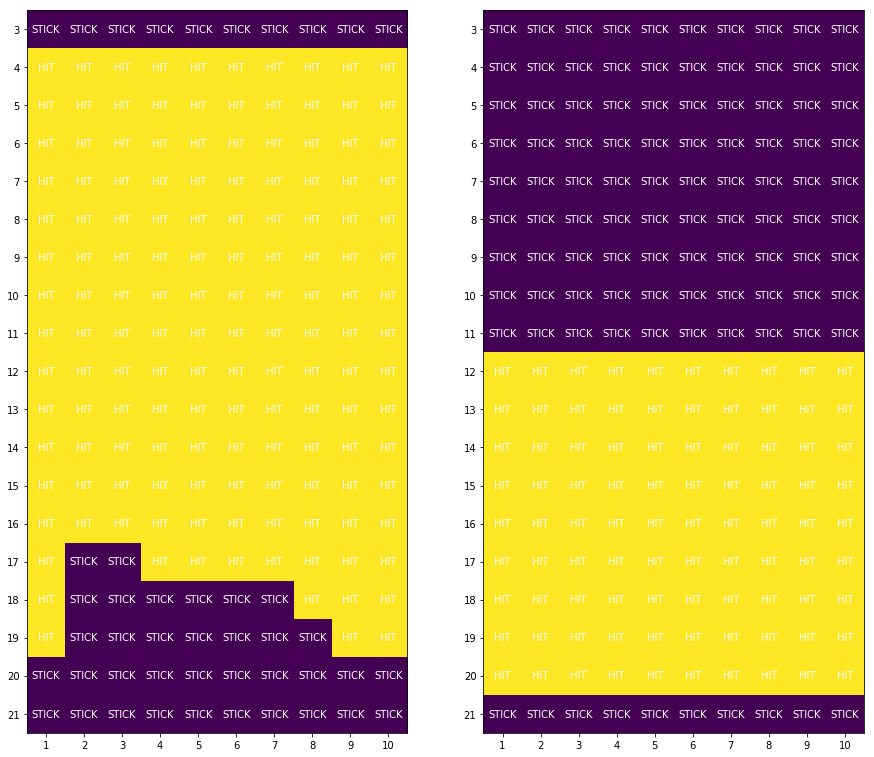

In [13]:
"""
A nice representation of the policy based on a matrix
"""

# TODO - remove the epsilon...
agent.temperature = 0.0

player_totals = list(range(3, 21 + 1))
dealer_cards = list(range(1, 10 + 1))
no_ace = np.zeros((len(player_totals), len(dealer_cards)))
with_ace = np.zeros((len(player_totals), len(dealer_cards)))

for i, player_total in enumerate(player_totals):
    for j, dealer_card in enumerate(dealer_cards):
        action = agent.get_action(VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=False))
        no_ace[i,j] = 1 if action == Action.HIT else 0
        action = agent.get_action(VisibleState(dealer_card=dealer_card, current_total=player_total, has_usable_ace=True))
        with_ace[i,j] = 1 if action == Action.HIT else 0

fig, ax = plt.subplots(figsize=(15, 30), ncols=2)
ax[0].imshow(no_ace)
ax[1].imshow(with_ace)

for k, heat_map in enumerate([no_ace, with_ace]):
    ax[k].set_yticks(np.arange(len(player_totals)))
    ax[k].set_xticks(np.arange(len(dealer_cards)))
    ax[k].set_yticklabels(player_totals)
    ax[k].set_xticklabels(dealer_cards)
    for i in range(len(player_totals)):
        for j in range(len(dealer_cards)):
            action_label = "HIT" if heat_map[i, j] == 1 else "STICK"
            text = ax[k].text(j, i, action_label, ha="center", va="center", color="w")

plt.show()